In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

from glob import glob
import os
import shutil

import numpy as np
import pandas as pd
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# AIM
## To classify the images into 
### IDC+
### IDC-

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [2]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


Image labelling

In [3]:
import random
#make directory for labelling
os.makedirs('../working/idc2/idc-minus/')     
os.makedirs('../working/idc2/idc-plus/')  


class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model
sampling_seed=0
size_4_training=5000
random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class1sample=random.sample(class1,size_4_training)


def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
            '''
            # first co
            status1=img = cv2.imread(i ,cv2.IMREAD_COLOR)
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            status2=cv2.imwrite(outputname,img)
            
            '''
            
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)
            shutil.copy(i, outputname)
   
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
   
class0path='../working/idc2/idc-minus/'
class1path='../working/idc2/idc-plus/'




read_and_save_data(class0path,class0sample)
read_and_save_data(class1path,class1sample)

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [4]:
img_size=224


In [5]:

from PIL import Image
import glob


In [6]:
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)


#import image

In [7]:
import cv2
'''
def readImage(path, X, Y, label):
    j=0
 
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img =cv2.resize(img,(50, 50))
        X.append(img)
        Y.append(label)
        j=j+1
        #if j==10:
        #    break
        
    return X, Y
    '''
def readImage(path, tag):
    j=0
    image_array = []
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
        image_array.append([img_resized, tag])
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_array

In [8]:
import numpy as np
'''
X=[]
Y=[]
X,Y =readImage(class0path, X, Y, 0)
X,Y =readImage(class1path, X, Y, 1)
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,2)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))
print(Y[19900:19999])
print(Y.shape)
print(X.shape)
'''

class0_array = readImage(class0path, 0)
class1_array = readImage(class1path, 1)
class0_array=np.array(class0_array)
class1_array=np.array(class1_array)
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)
print(class0_array.shape)
print(combined_data.shape)

X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)
#print(X.shape)
#pring(y.shape)

# reshape X data
X = np.array(X).reshape(-1, img_size, img_size, 3)
print(X.shape)

(5000, 2)
(10000, 2)
(10000, 224, 224, 3)


In [9]:
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(7000, 224, 224, 3) (900, 224, 224, 3) (2100, 224, 224, 3) (7000, 2) (900, 2) (2100, 2)


In [10]:
#Callbacks
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
nClasses=2

# MobileNet

In [11]:
'''
#base_Neural_Net= MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
from keras.applications.vgg16 import VGG16
base_vgg16=VGG16(include_top=False, input_shape=(50, 50, 3), weights='imagenet')
for layer in base_vgg16.layers:
    layer.trainable = False
model=Sequential()
model.add(base_vgg16)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.summary()
'''
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.applications import DenseNet169
base_model = DenseNet169(
    #weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
# fix pretrained layers for deep feature extraction
base_model.trainable = False
# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

2022-05-06 22:21:17.412995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 22:21:17.418669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 22:21:17.419644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 22:21:17.421942: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

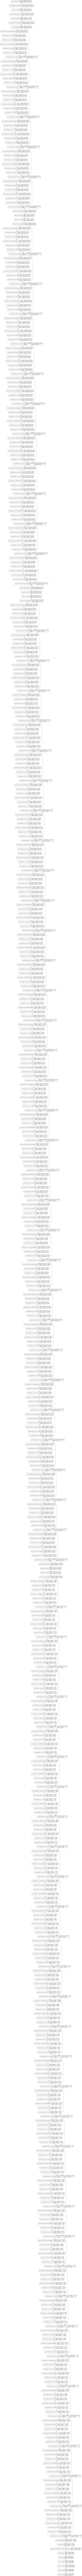

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [13]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint('model.hdf5', save_best_only=True)]
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 30,callbacks=callbacks)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.87 µs


2022-05-06 22:21:31.096954: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.
2022-05-06 22:21:32.283206: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.
2022-05-06 22:21:33.128204: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-06 22:21:43.489066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


219/219 [==============================] - 40s 108ms/step - loss: 2.2469 - accuracy: 0.8467 - val_loss: 0.3406 - val_accuracy: 0.8667
Epoch 2/30
219/219 [==============================] - 20s 90ms/step - loss: 0.3227 - accuracy: 0.8624 - val_loss: 0.3141 - val_accuracy: 0.8689
Epoch 3/30
219/219 [==============================] - 19s 85ms/step - loss: 0.3171 - accuracy: 0.8670 - val_loss: 0.3152 - val_accuracy: 0.8700
Epoch 4/30
219/219 [==============================] - 19s 85ms/step - loss: 0.3040 - accuracy: 0.8720 - val_loss: 0.3019 - val_accuracy: 0.8733
Epoch 5/30
219/219 [==============================] - 19s 85ms/step - loss: 0.3008 - accuracy: 0.8743 - val_loss: 0.3004 - val_accuracy: 0.8600
Epoch 6/30
219/219 [==============================] - 18s 84ms/step - loss: 0.3001 - accuracy: 0.8776 - val_loss: 0.3115 - val_accuracy: 0.8700
Epoch 7/30
219/219 [==============================] - 19s 86ms/step - loss: 0.2979 - accuracy: 0.8763 - val_loss: 0.2880 - val_accuracy: 0.8733
Ep

In [15]:
'''
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)
'''


"\nc1=PlotLossesKeras()\nmodel.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])\nhistory=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)\n"

In [16]:
'''
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
'''

"\nmodel.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)\nopt = Adam(learning_rate=0.001)\nmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])\n"

In [17]:
'''
print("Performance Report:")
#y_pred5=model.predict_classes(x_test)
predict_x=model.predict(x_test) 
classes_x=np.argmax(predict_x,axis=1)
y_pred5=classes_x

y_test5=[np.argmax(x) for x in y_test]
#y_pred_prb5=model.predict_proba(x_test)
predict_prob=model.predict(x_test)
predict_classes=np.argmax(predict_prob,axis=1)
y_pred_prb5=predict_classes

target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test5, y_pred5),4))
print('Precision score is :', np.round(metrics.precision_score(y_test5, y_pred5, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test5,y_pred5, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test5, y_pred5, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test5, y_pred_prb5,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test5, y_pred5,target_names=target))
'''

'\nprint("Performance Report:")\n#y_pred5=model.predict_classes(x_test)\npredict_x=model.predict(x_test) \nclasses_x=np.argmax(predict_x,axis=1)\ny_pred5=classes_x\n\ny_test5=[np.argmax(x) for x in y_test]\n#y_pred_prb5=model.predict_proba(x_test)\npredict_prob=model.predict(x_test)\npredict_classes=np.argmax(predict_prob,axis=1)\ny_pred_prb5=predict_classes\n\ntarget=["G","F","D"]\nfrom sklearn import metrics\nprint(\'Accuracy score is :\', np.round(metrics.accuracy_score(y_test5, y_pred5),4))\nprint(\'Precision score is :\', np.round(metrics.precision_score(y_test5, y_pred5, average=\'weighted\'),4))\nprint(\'Recall score is :\', np.round(metrics.recall_score(y_test5,y_pred5, average=\'weighted\'),4))\nprint(\'F1 Score is :\', np.round(metrics.f1_score(y_test5, y_pred5, average=\'weighted\'),4))\nprint(\'ROC AUC Score is :\', np.round(metrics.roc_auc_score(y_test5, y_pred_prb5,multi_class=\'ovo\', average=\'weighted\'),4))\nprint(\'\t\tClassification Report:\n\', metrics.classificati

In [18]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

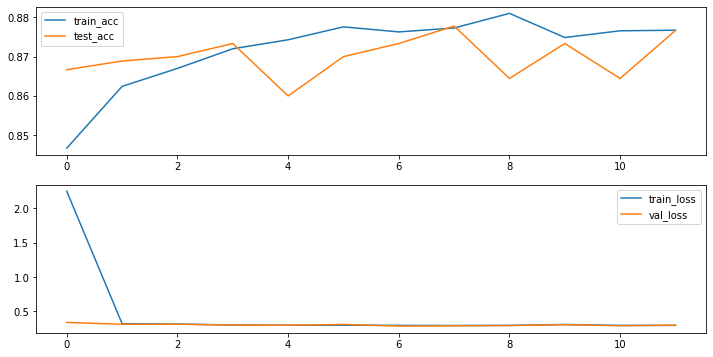

In [20]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

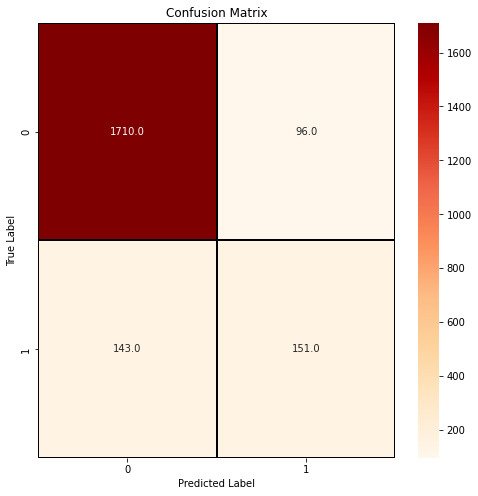

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [22]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1806
           1       0.61      0.51      0.56       294

    accuracy                           0.89      2100
   macro avg       0.77      0.73      0.75      2100
weighted avg       0.88      0.89      0.88      2100



In [23]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('model.hdf5')

/kaggle/working


/kaggle/working/model.hdf5

In [24]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train=np.argmax(y_train, axis=1)
    y_test=np.argmax(y_test, axis=1)
    y_val=np.argmax(y_val, axis=1)
    y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    #ps:all the Y value must turn back to 1 dimension array. otherwise, the scoring functions in sklearn cannot compare, and will give an error
    #classification metrics can't handle a mix of continuous-multioutput and multi-label-indicator targets
    
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, y_train_pred)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

2022-05-06 22:26:13.448970: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.
2022-05-06 22:26:14.708904: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.


Train accuracy Score------------>
88.429 %
Val accuracy Score--------->
88.619 %
Test accuracy Score--------->
87.667 %
F1 Score--------------->
87.586 %
Cohen Kappa Score------------->
55.954 %
Recall-------------->
87.667 %
Precision-------------->
87.512 %


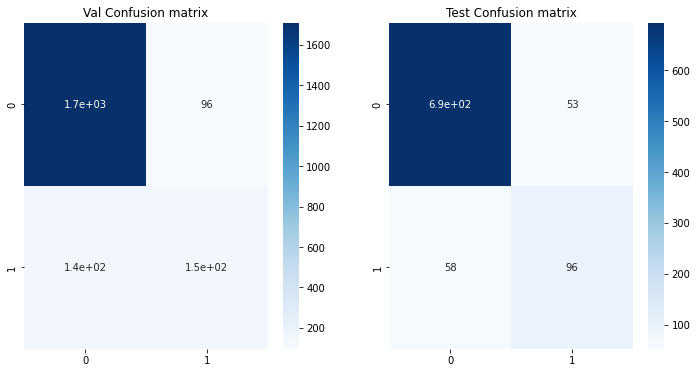

In [25]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)